In [14]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt

from cloudpickle import dump
from feature_engine.datetime import DatetimeFeatures
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
)

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

Define a useful helper function for adding time-related features to df, based on timestamp column

In [2]:
def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

Load the data

In [3]:
weather_data = pd.read_csv("data/DCweather_clean.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')

In [4]:
ride_counts_all = pd.read_csv("data/ride_counts_ALL.csv", parse_dates=['time'])

In [5]:
# define training, validation (and test splits)
# dataset starts 2021-03-01, ends 2023-05-31
end_train = '2023-2-28 23:59:00'
end_val = '2023-05-31 23:59:00'

In [6]:
# Current data is at hourly resolution, but this might be overkill. Here's how I would downsample the ride counts to every 2 hours.
# Exactly what timescale is best operationally depends on how frequently bikes might be moved around

# rule = "2H"
# SAMPLES_PER_DAY = 12

# ride_counts_all = ride_counts_all.resample(rule, on='time').sum().reset_index()
# weather_data = weather_data.asfreq(rule)

In [7]:
# add time features, and join with weather data on time index

data = ride_counts_all.loc[:, ['time', 'rides_out', 'rides_in']]
data = add_time_features(data, 'time').set_index('time')
data = data.join(weather_data).asfreq("H").ffill()

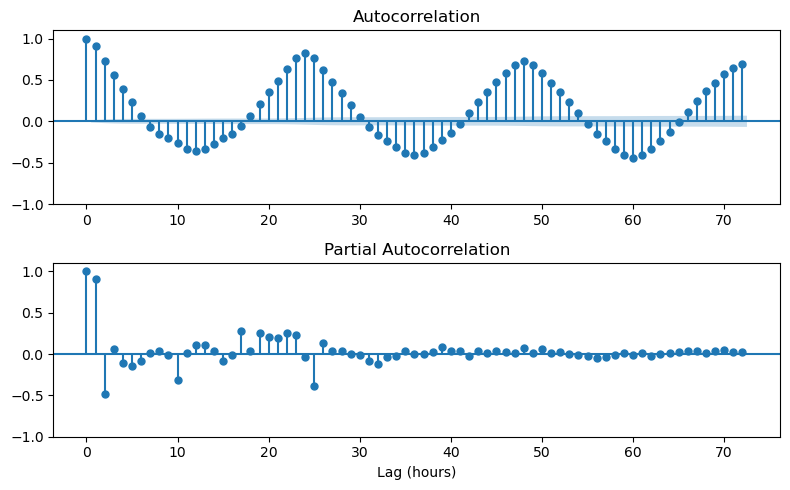

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8,5))
plot_acf(data['rides_out'], lags=72, ax=axs[0])
plot_pacf(data['rides_out'], lags=72, ax=axs[1])
axs[0].set_ylim([-1, 1.1])
axs[1].set_ylim([-1, 1.1])
axs[1].set_xlabel('Lag (hours)')
fig.tight_layout()
plt.savefig('figs/acf_pacf_whitebkgd.png', format='png', transparent=False)
plt.show()

In [10]:
# the net ride count is the number of bikes being docked in minus the bikes being taken out.
# Across the whole network these two counts are very closely related, because most rides are short (30 mins or less).
# This could be more useful once I look at a more local level

data['net_rides'] = data['rides_in'] - data['rides_out']

In [11]:
# split the data into training, validation and test sets
# since working with time series, these must be sequential (to avoid leakage, or "forward-looking"!)
data_col = 'rides_out'
data_train = data.loc[:end_train, data_col]
data_val = data.loc[end_train:end_val, data_col]
data_test = data.loc[end_val:, data_col]

Before building the model, I want to apply some additional feature engineering.
I could treat hour and month as categorical or ordinal variables, but this would either expand the feature space and/or not capture the cyclic nature of these variables.
For example, hour 23 and hour 0 are furthest apart in a numeric sense, but are very close in time. Using cyclic transformations (sine and cosine), I can capture this relationship better. 

This might not be critical for tree-based methods which can deal with non-linear interactions, but if I were to use a linear method, this would be very important.
Also here I use an ordinal encoder for weather condition, season categories, and year.
Boolean categories can be encoded as ordinal, effectively 0 and 1.

sklearn provides the neat ColumnTransformer object which allows me to build a pipeline and engineer columns independently. The same transformations will be applied to training and any future test sets going into the same pipeline, which saves the hassle (and potential mistakes) of doing those transformations manually.

In [33]:
# Create data transformers

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi),
                               feature_names_out='one-to-one',
                               validate=False)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi),
                               feature_names_out='one-to-one',
                               validate=False)

# exogenous data column transformer
categorical_columns = [
    "is_workday",
    "is_holiday",
    "rush_hour",
    #"condition",
    #"season",
    "year",
]

categories = [
    [False, True],
    [False, True],
    [False, True],
    #["rainy", "cloudy", "clear"],
    #["Winter", "Autumn", "Spring", "Summer"], # maybe should be categorical..
    [2021, 2022, 2023],
]

transformer_exog = ColumnTransformer(
    transformers=[
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("categories", OrdinalEncoder(categories=categories), categorical_columns)
    ],
    remainder='passthrough',
)

Time series models can accommodate exogenous features, which I define here. Notably, the majority of these are pure time-related features, such as hour, day-of-week etc, which can be known in the future and used for prediction. These can be termed "future covariates"

In this model I include weather data as well, although for genuine models for future predictions, I would either need to accommodate weather forecasts, not include weather as a covariate, or only allow it to be a past covariate.

In [34]:
def define_exog(data, data_cols):
    exog = data.drop(data_cols, axis=1)
    exog.drop(["date", "quarter", "feelslike", "visibility"], axis=1, inplace=True)
    exog[['year', 'day_of_week', 'weekend']] = exog[['year', 'day_of_week', 'weekend']].astype("category")
    exog['rush_hour'] = ((exog['hour'] > 5) & (exog['hour'] <= 9)) | ((exog['hour'] >= 16) & (exog['hour'] < 20))
    #exog['condition'].replace({'rainy':0, 'cloudy':1, 'clear':2}, inplace=True)
    #exog['season'].replace({'Winter':0, 'Autumn':1, 'Spring':1, 'Summer':2}, inplace=True)
    return exog


exog_cols = ['year', 'month', 'hour', 'is_workday', 'is_holiday', 'rush_hour']
exog = define_exog(data, ['rides_out', 'rides_in'])

#### Forecasting model

Now I train a forecasting model, using the [skforecast](https://skforecast.org/0.9.0/index.html) package.
skforecast accommodates standard sklearn regressors as forecaster models, adding in desired time lags and exogenous features, and grid-search cross-validation

First check what our features look like under transformation

In [37]:
models = [XGBRegressor(random_state=123),
          HistGradientBoostingRegressor(random_state=123),
          LGBMRegressor(random_state=123)]

# Hyperparameter to search for each model
param_grids = {'XGBRegressor': {'n_estimators': [10, 20, 50, 100], 'max_depth': [5, 10, 15, 20]},
               'HistGradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 1], 'max_depth': [5, 10, 15, 20]},
               'LGBMRegressor': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 20, 50, 100], 'max_depth': [5, 10, 15, 20]},
               }

metrics = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']

# Lags used as predictors
lags_grid = [1, [1, 24], [1, 24, 24*7]]

# initialize a df to store the results for all models
df_results = pd.DataFrame()
all_forecasters = {}

for i, model in enumerate(models):

    forecaster = ForecasterAutoreg(
            regressor = model,
            lags      = 3, # Placeholder, the value will be overwritten by grid_search
            transformer_exog=transformer_exog,
            )

    param_grid = param_grids[list(param_grids)[i]]

    results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, data_col],
                   exog               = exog.loc[:end_val, exog_cols],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 24*7,
                   refit              = False,
                   metric             = metrics,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

    # Create a column with model name
    results_grid['model'] = list(param_grids)[i]

    df_results = pd.concat([df_results, results_grid])

    # save the forecasters
    all_forecasters[list(param_grids.keys())[i]] = forecaster

df_results = df_results.sort_values(by='mean_absolute_error')

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'max_depth': 5, 'n_estimators': 20}
  Backtesting metric: 35659.088035894994

Number of models compared: 36.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5}
  Backtesting metric: 35025.39712707484

Number of models compared: 144.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/48 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 34541.929762859465



In [41]:
df_results['max_depth'] = df_results['max_depth'].astype(int)
df_results[['mean_squared_error', 'mean_absolute_error']] = np.round(df_results[
    ['mean_squared_error', 'mean_absolute_error']], 2)
df_results[['model', 'lags', 'max_depth', 'n_estimators', 'learning_rate',
            'mean_squared_error', 'mean_absolute_error']].head(10)

,model,lags,max_depth,n_estimators,learning_rate,mean_squared_error,mean_absolute_error
123,LGBMRegressor,"[1, 24, 168]",15,100.0,0.1,34541.93,110.38
127,LGBMRegressor,"[1, 24, 168]",20,100.0,0.1,34735.40,110.77
119,LGBMRegressor,"[1, 24, 168]",10,100.0,0.1,35379.47,111.52
28,HistGradientBoostingRegressor,"[1, 24, 168]",5,NaN,0.1,35025.40,111.73
29,HistGradientBoostingRegressor,"[1, 24, 168]",10,NaN,0.1,35521.82,112.28
115,LGBMRegressor,"[1, 24, 168]",5,100.0,0.1,35755.09,112.28
118,LGBMRegressor,"[1, 24, 168]",10,50.0,0.1,35419.30,112.50
126,LGBMRegressor,"[1, 24, 168]",20,50.0,0.1,35357.02,112.62
122,LGBMRegressor,"[1, 24, 168]",15,50.0,0.1,35357.02,112.62
34,XGBRegressor,"[1, 24, 168]",5,50.0,NaN,36163.16,113.05


Also check check here what our feature matrix looks like (with the column transformers applied)

In [42]:
train_X, train_y = forecaster.create_train_X_y(
    y=data.loc[:end_val, data_col],
    exog=exog.loc[:end_val, exog_cols],
)
train_X.head()

,lag_1,lag_24,lag_168,month_sin__month,month_cos__month,hour_sin__hour,hour_cos__hour,categories__is_workday,categories__is_holiday,categories__rush_hour,categories__year
time,,,,,,,,,,,
2021-03-08 00:00:00,29.0,49.0,14.0,1.0,6.123234e-17,0.000000,1.000000,1.0,0.0,0.0,0.0
2021-03-08 01:00:00,12.0,35.0,4.0,1.0,6.123234e-17,0.258819,0.965926,1.0,0.0,0.0,0.0
2021-03-08 02:00:00,5.0,18.0,3.0,1.0,6.123234e-17,0.500000,0.866025,1.0,0.0,0.0,0.0
2021-03-08 03:00:00,3.0,12.0,1.0,1.0,6.123234e-17,0.707107,0.707107,1.0,0.0,0.0,0.0
2021-03-08 04:00:00,3.0,5.0,8.0,1.0,6.123234e-17,0.866025,0.500000,1.0,0.0,0.0,0.0


Testing in time series modelling can be applied using "backtesting". Backtesting on previous training data provides a useful benchmark for what we might expect on the test data.

In [34]:
# Backtesting on training data
# ==============================================================================
best_forecaster = all_forecasters['XGBRegressor']

metric, predictions_test = backtesting_forecaster(
                            forecaster         = best_forecaster,
                            y                  = data.loc[:end_val, data_col],
                            exog=exog.loc[:end_val, exog_cols],
                            initial_train_size = None,
                            fixed_train_size   = False,
                            steps              = 24*7,
                            refit              = False,
                            metric             = ['mean_squared_error', 'mean_absolute_error'],
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest mse: {metric[0]:.2f}, mae: {metric[1]:.2f}")

  0%|          | 0/117 [00:00<?, ?it/s]

Backtest mse: 14696.43, mae: 74.62


The good thing about a model based on decision trees is that a human-understandable feature importance can be extracted. This tells us that lag_1 is the most important feature, followed by lag_168 and hour_cos.
lag_168 is the ride count at the same time the week before (so the same hour and same day of the week).
The cosine of the hour captures the periodicity of the daily bike counts, as the cosine period of hour is 0 when hour=12, and 1 when hour is 0.

In [36]:
feature_importances = best_forecaster.regressor.feature_importances_
feature_names = best_forecaster.regressor.feature_names_in_
features_dict = {k:np.round(v,3) for k,v in zip(feature_names, feature_importances)}
features_df = pd.DataFrame.from_dict(data=features_dict, orient='index', \
                                     columns=["importance"]).sort_values(by="importance", ascending=False)
features_df

,importance
lag_1,0.635
lag_168,0.107
hour_cos__hour,0.101
hour_sin__hour,0.039
categories__is_workday,0.039
lag_24,0.026
categories__condition,0.017
categories__rush_hour,0.010
month_cos__month,0.006
categories__is_holiday,0.005


In [37]:
# Backtesting (evaluation) on test data
# ==============================================================================
best_forecaster = all_forecasters['XGBRegressor']

metric, predictions_test = backtesting_forecaster(
                            forecaster         = best_forecaster,
                            y                  = data.loc[:, data_col],
                            exog=exog.loc[:, exog_cols],
                            initial_train_size = len(data.loc[:end_val, data_col]),
                            fixed_train_size   = False,
                            steps              = 24*28,
                            refit              = False,
                            interval           = [5, 95],
                            n_boot             = 100,
                            metric             = ['mean_squared_error', 'mean_absolute_error'],
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest mse: {metric[0]:.2f}, mae: {metric[1]:.2f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Backtest mse: 21500.60, mae: 101.15


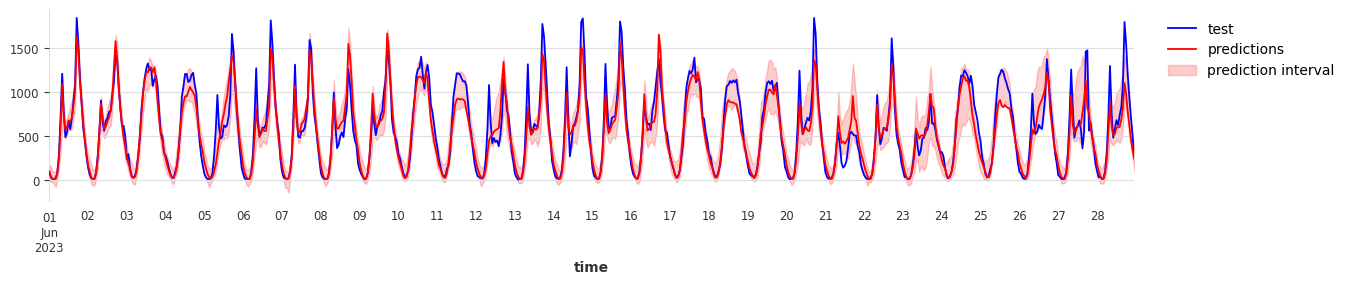

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(14, 2.5))
#data_val.iloc[-24*14:].plot(ax=ax, label='val', color='k')
data_test.iloc[:24*28].plot(ax=ax, label='test', color='b')
predictions_test['pred'][:24*28].plot(ax=ax, label='predictions', color='r')
ax.fill_between(
    predictions_test.index,
    predictions_test['lower_bound'],
    predictions_test['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
_ = ax.legend(bbox_to_anchor=(1.02, 1))

plt.savefig("figs/allrides_XGBbest_testpred_wseason.png", format="png", transparent=True, bbox_inches="tight")

To save the model I use cloudpickle, as standard pickle cannot handle the lambda objects in my cyclic feature transformers.

In [20]:
from cloudpickle import dump

with open("XGB_testmodel.pkl", "wb") as pkl_file:
        dump(best_forecaster, pkl_file)